In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno
from scipy.stats import norm #Analysis 
from scipy import stats #Analysis 

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)
df_original= df_train.copy()
df_origin_test = df_test.copy()

In [3]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

### 1.1 목적변수 시각화

price의 경우 집을 구매한 시점의 가격 -> 그 시기의 가격

In [5]:
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [6]:
y = df_train['price']

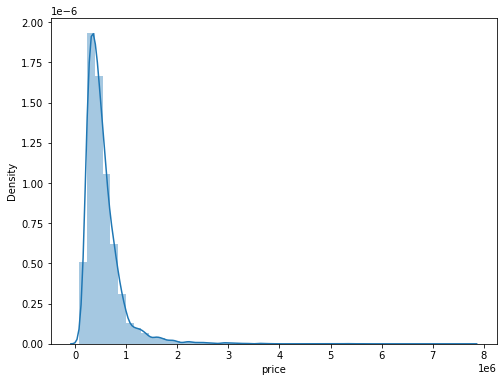

In [7]:
f, ax = plt.subplots(figsize = (8, 6))
sns.distplot(y)
plt.show()

In [8]:
print('Skewness : %f' %df_train['price'].skew())
print('Kurtosis : %f' %df_train['price'].kurt())

Skewness : 4.290252
Kurtosis : 40.154919


- 왜도 : 오른쪽 꼬리가 길 수록 크다
- 첨도 : 3에 가까울 수록 정규분포에 가깝다, 3보다 작으면 정규분포보다 평탄한것, 3보다 크면 더 뾰족한 것을 말한다.

회귀 모델 사용

- 첨도 왜도가 매우큼, 분산도 큼 => noramalize를 통해 price가 정규분표를 가지도록 만들어줘야댐

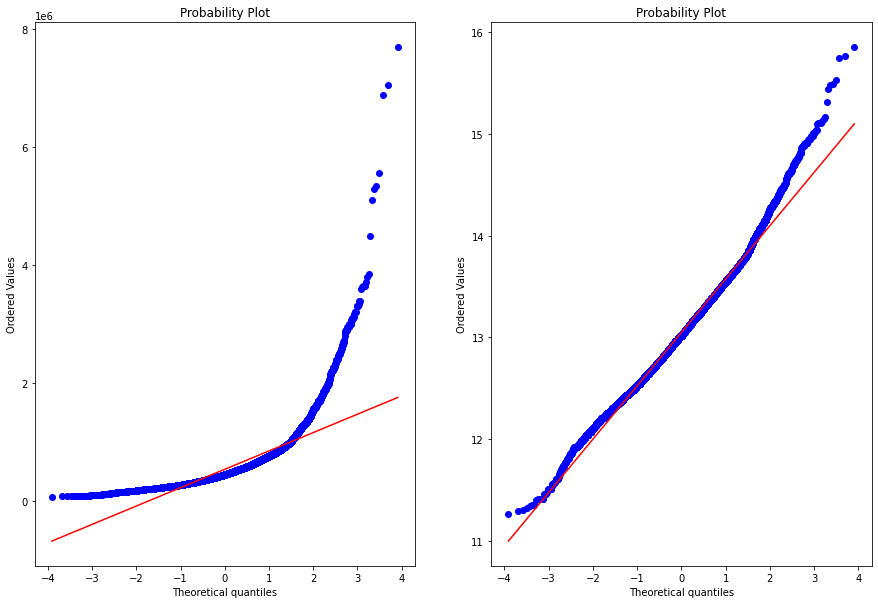

In [9]:
fig = plt.figure(figsize = (15, 10))

fig.add_subplot(1, 2, 1)
res = stats.probplot(df_train['price'], plot = plt)

fig.add_subplot(1, 2, 2)
res = stats.probplot(np.log1p(df_train['price']), plot = plt)

log가 정규분포를 갖도록 해준다.

<AxesSubplot:xlabel='price', ylabel='Density'>

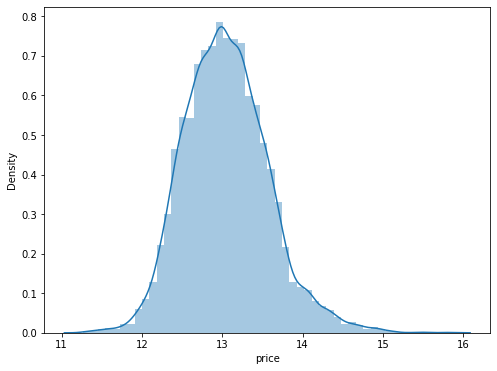

In [10]:
df_train['price'] = np.log1p(df_train['price'])

f, ax = plt.subplots(figsize = (8, 6))
sns.distplot(df_train['price'])

### 1.2 각 변수들의 분포 확인

In [11]:
df_train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [12]:
df_train['date'] = df_train['date'].apply(lambda x : str(x[:6])).astype(str)
df_test['date'] = df_train['date'].apply(lambda x : str(x[:6])).astype(str)
data = df_train.copy()
del data['id']
del data['price']

In [13]:
data.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  object 
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

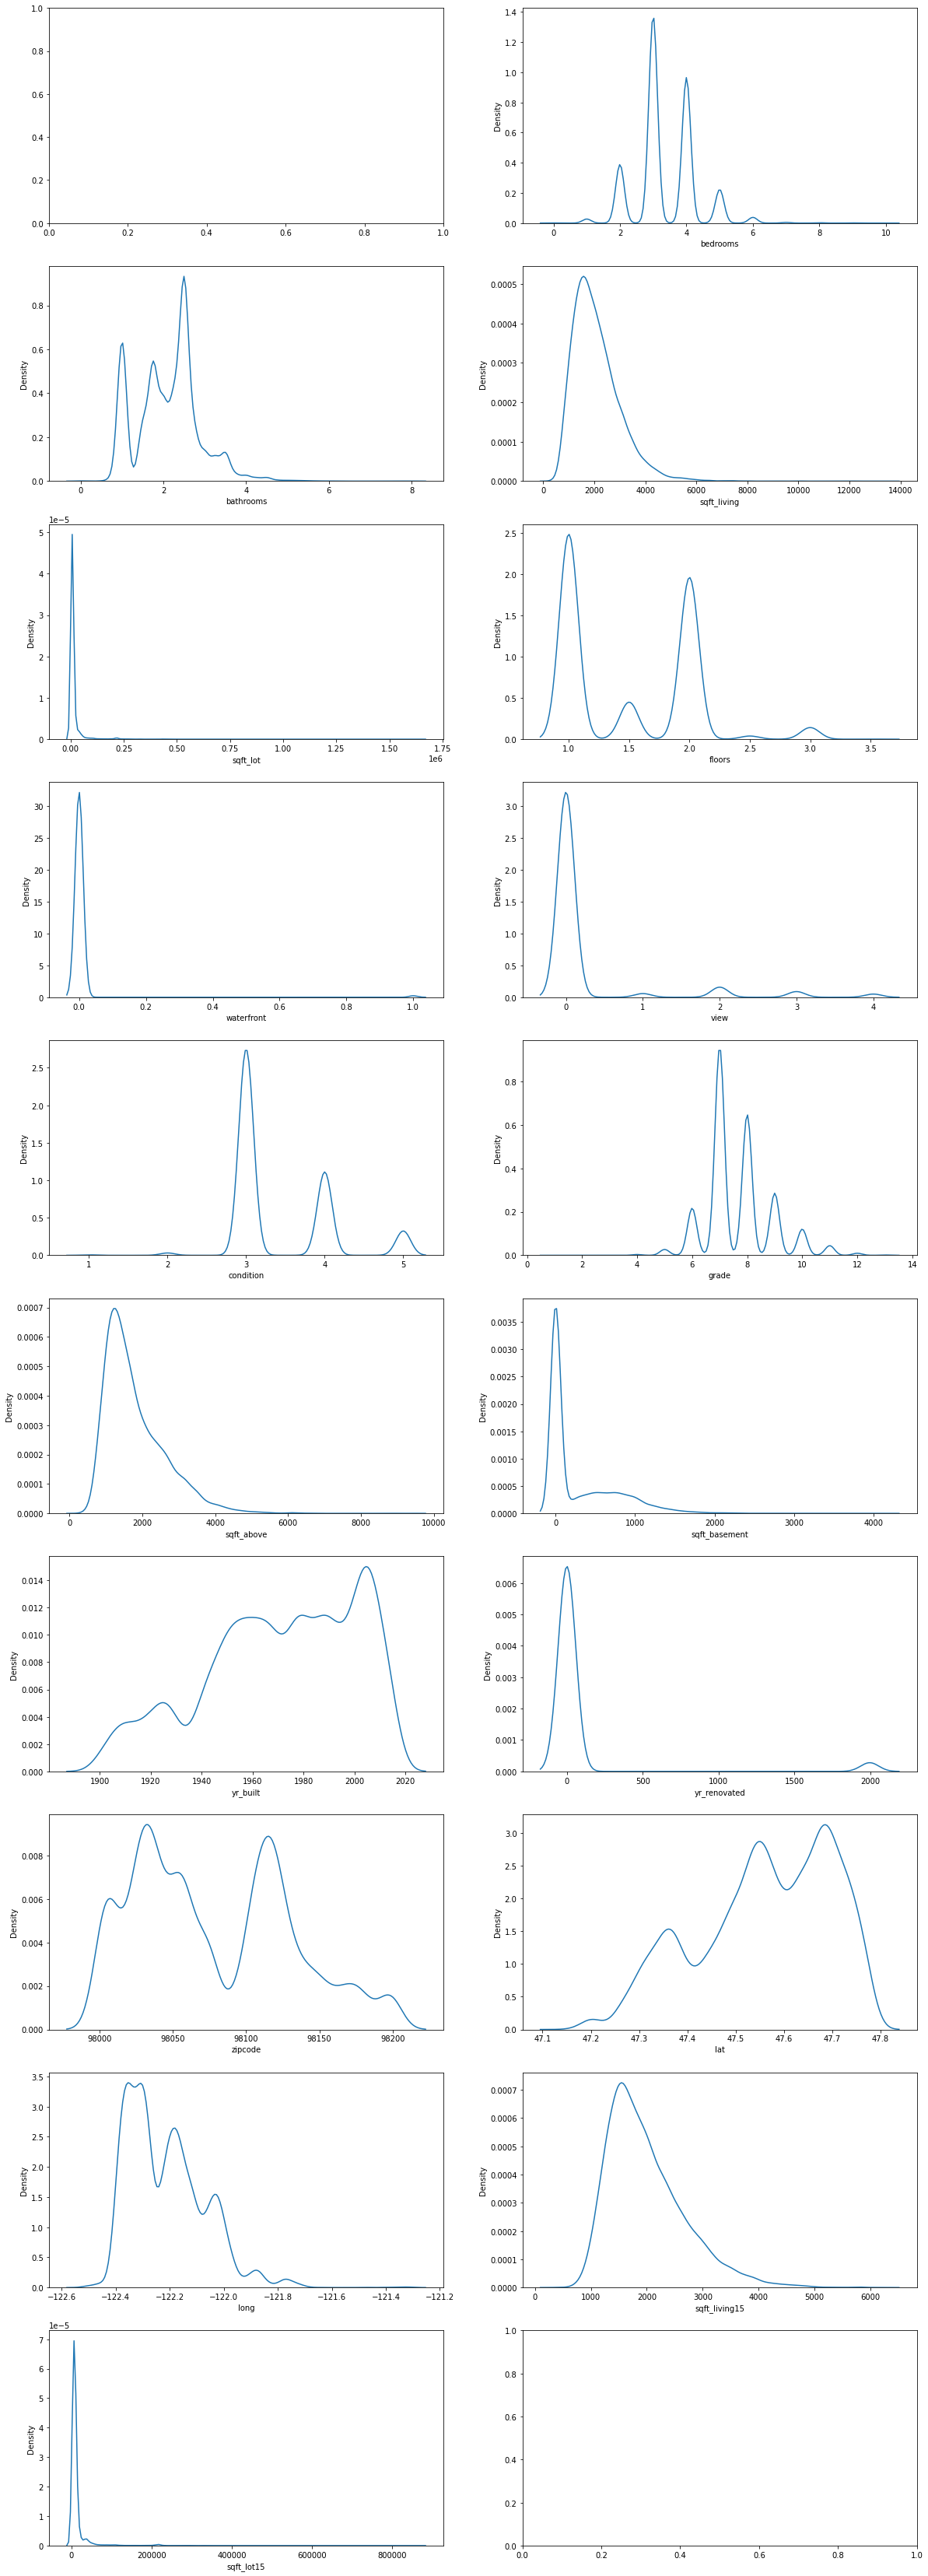

In [15]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        if count == 0:
            count +=1
            continue
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        #ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

sqft_living, sqft_basement, sqft_above, sqft_living15 분포들이 치우쳐져있음을 확인 => 정규화필요

### 1.3 목적변수인 가격과 가장 상관관계가 높은 10개의 변수를 히트맵

- 피어슨 상관관계 : 연속형 변수에 사용
- 스피어만 순위 상관관계 : 범주형 변수도 포함되어있을 경우 사용(범주형 변수가 순위를 가질떄)
  => 꼭 선형적인 관계에 대한 관계가 아닌 단조적 증가 감소에 대한 값

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

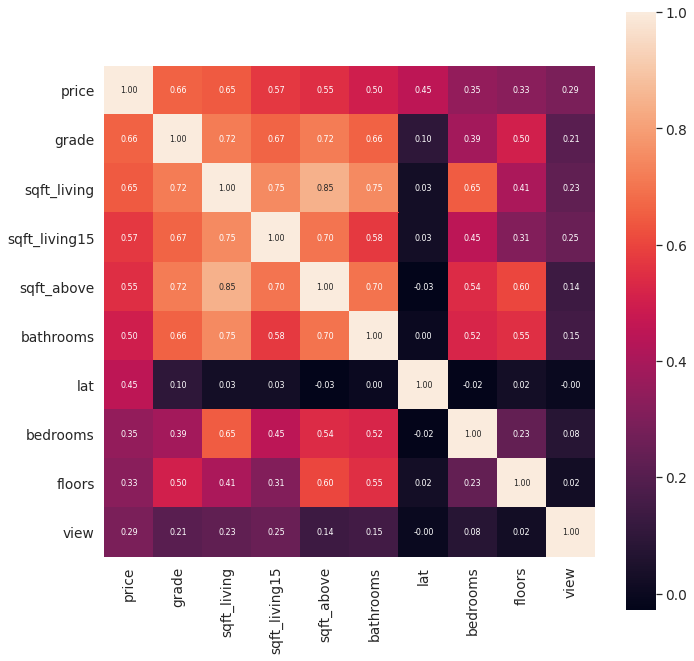

In [16]:
import scipy as sp

cor_abs = abs(df_train.corr(method = 'spearman'))
cor_cols = cor_abs.nlargest(10, columns = 'price').index #price와 correlation이 높은 column 10개 추출
#spearman coefficient matrix

cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0]
print(cor_cols.values)#
plt.figure(figsize = (11, 11))
sns.set(font_scale = 1.25)
sns.heatmap(cor, fmt = '.2f', annot = True, square = True, annot_kws = {'size' : 8}, xticklabels = cor_cols.values, yticklabels = cor_cols.values)



- price와 상관도가 높은 변수는 집의 등급, 주거공간의 크기, 전체 크기순
- 위의 지역은 시애틀 => 북쪽으로 갈 수록 살기 좋은 집들이 많다고한다.

### 1.4 각 변수들과 price사이의 관계 분석

#### 1.4.1 grade

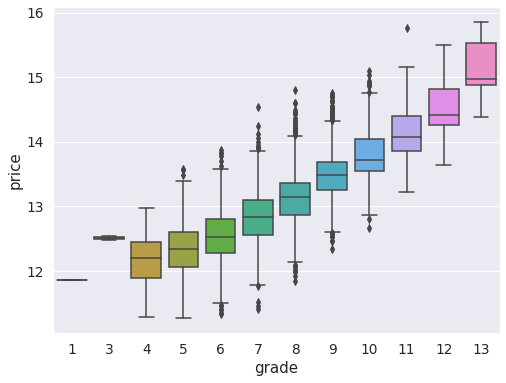

In [17]:
data = pd.concat([df_train['price'], df_train['grade']], axis = 1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.boxplot(x='grade', y = 'price', data = data)

- 등급 3의 경우 값이 큰이유
- 등급 7, 8, 9에서 이상치가 많은이유
- 등급 8, 11에서 차이가 큰 이상치가 나타나는 이유

3가지에 대해서 관찰해볼 필요가 있다.

#### 1.4.2 sqft_living

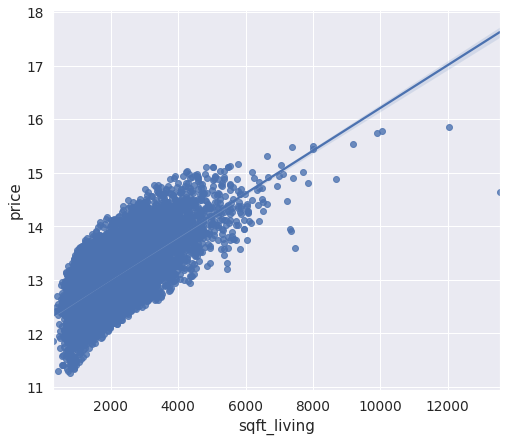

In [18]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis = 1)
f, ax = plt.subplots(figsize = (8, 7))
fig = sns.regplot(x='sqft_living', y = 'price', data = data)

- sqft_living : 주거 평방 피트 => 실제 사용면적
- sqlf_lot : 부지 평방피트 => 총 부지의 면적

sqft_living이 12를 넘는값에 대해서 확인해 본다

#### 1.4.3 sqft_living

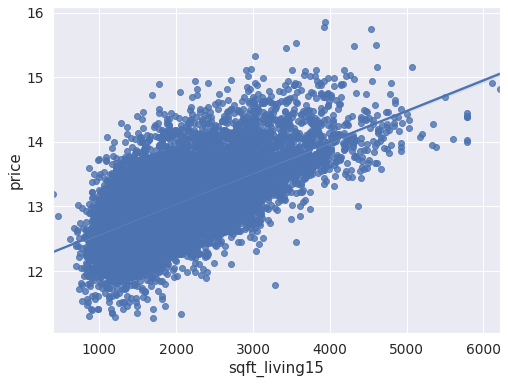

In [19]:
data = pd.concat([df_train['price'], df_train['sqft_living15']], axis = 1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.regplot(x = 'sqft_living15', y = 'price', data = data)

- 대체적으로 가격의 분산이 큰 것을 확인할 수 있다.
- sqft_living15 => 15년도 기준의 평방피트 (가장가까운 15개 이웃들의 평균이라는 말이있음)
- 재건축을 했다면 sqft_living => sqft_living15수치가 바뀌었을수있음

#### 1.4.4 sqft_above

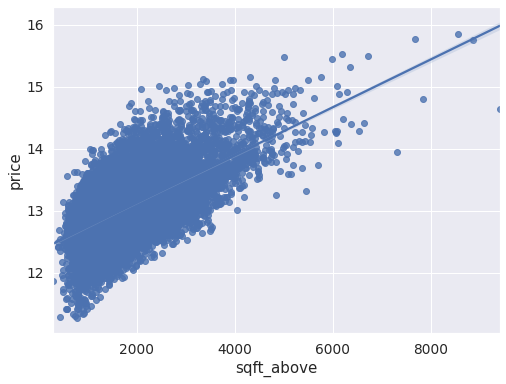

In [20]:
data = pd.concat([df_train['price'], df_train['sqft_above']], axis = 1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.regplot(x='sqft_above', y = 'price', data = data)

price에 대한 분산은 sqft_living 15보단 심해보이지는 않은것같음

#### 1.4.5 bathrooms

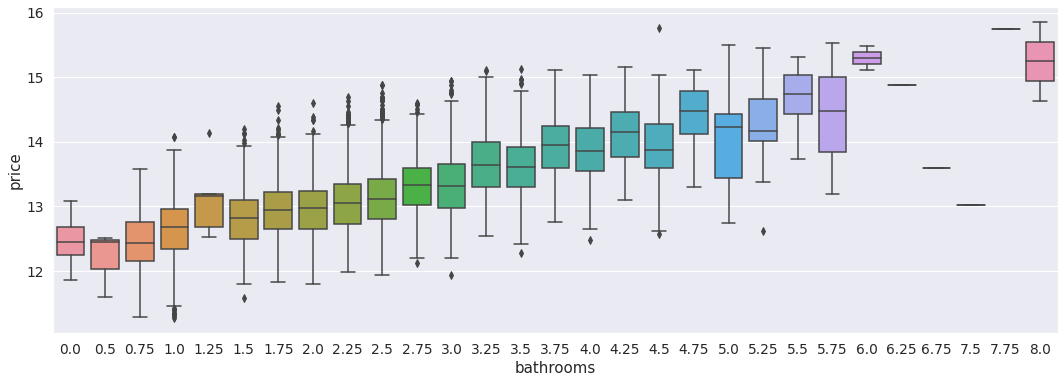

In [21]:
data = pd.concat([df_train['price'], df_train['bathrooms']], axis = 1)
f, ax = plt.subplots(figsize = (18, 6))
fig = sns.boxplot(x = 'bathrooms', y = 'price', data = data)

- 소숫점 때문에 확실한 갯수를 구분하기 힘듬

#### 1.4.6 bedrooms

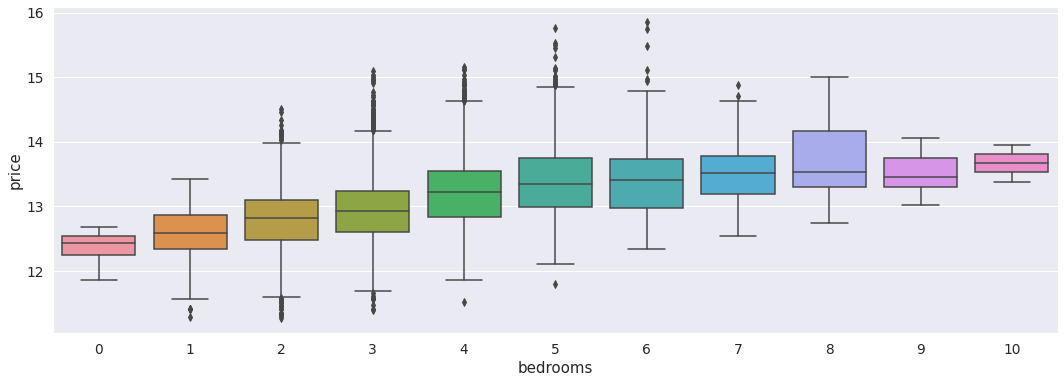

In [22]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis = 1)
f, ax = plt.subplots(figsize = (18, 6))
fig = sns.boxplot(x = 'bedrooms', y = 'price', data = data)

- median 값들은 비교적 선형적 관계를 띄고 있음
- 방이 적음에도 불구하고 가격이 높은 이상치가 보임 => 땅값이 높은 곳일 수 있음

### 1.5 결측치확인

In [23]:
df_train.isnull().sum() #결측치 없음

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### 1.6 범주형 변수의 유니크한 갯수

In [24]:
train_unique = []
columns = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade']
df_unique_count = df_train[columns].apply(lambda x : x.nunique())

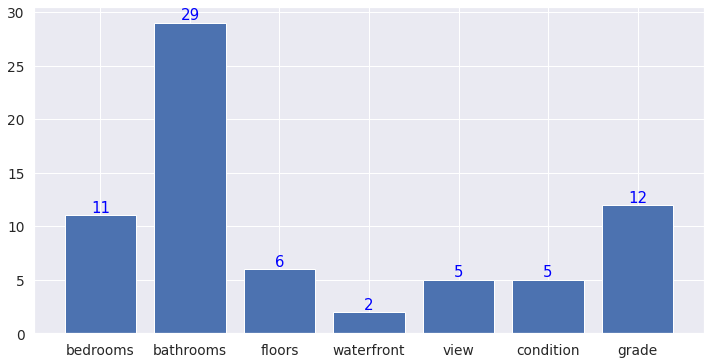

In [25]:
plt.figure(figsize = (12, 6))
plt.bar(df_unique_count.index, df_unique_count.values)
for i, v in enumerate(df_unique_count.index):
    plt.text(v, df_unique_count.values[i], df_unique_count.values[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 15, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

In [26]:
df_train['floors'].unique() 

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [27]:
df_train['view'].unique()

array([0, 3, 4, 2, 1])

층수가 소수점?

=> 다락방을 낀 형태

## 2. 데이터 전처리

### 2.1 이상치 제거

sqft_living, grade, bedrooms에 대한 이상치 확인 및 처리

#### 2.1.1 sqft_living

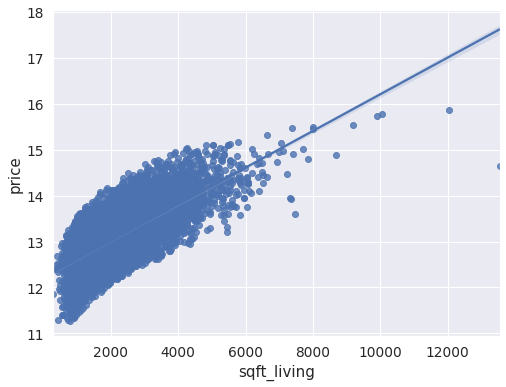

In [28]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis = 1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.regplot(x = 'sqft_living', y = 'price', data = data)

In [29]:
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


sqft_living 이 price에 결정적 영향을 미치지만 이 집은 굉장히 주거공간이넓은데에 비하여 price가 작고, 이는 학습에 부정적 영향을 미칠 수 있다.

In [30]:
df_train = df_train.loc[df_train['id']!= 8912]

In [31]:
len(df_train)

15034

#### 2.1.2 grade

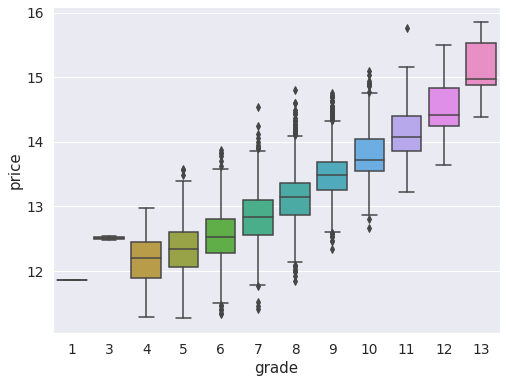

In [32]:
data = pd.concat([df_train['price'], df_train['grade']], axis = 1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.boxplot(x='grade', y = 'price', data = data)

##### 1) grade = 3일때의 이상치 확인

In [33]:
df_train.loc[(df_train['price'] > 12) & (df_train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,201502,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,201411,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [34]:
df_train[df_train['zipcode'] == 98022].describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,159.000000,159.000000,159.000000,159.000000,159.000000,1.590000e+02,159.000000,159.0,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.0,159.000000,159.000000,159.000000,159.000000
mean,7234.477987,12.613374,3.157233,1.891509,1821.471698,7.324781e+04,1.323899,0.0,0.666667,3.729560,7.163522,1720.716981,100.754717,1972.088050,75.289308,98022.0,47.211259,-121.995736,1801.018868,52247.672956
std,4227.574178,0.321977,0.707416,0.641725,695.248019,1.688287e+05,0.443442,0.0,1.151041,0.776926,1.011793,617.044263,319.589426,29.031494,381.395312,0.0,0.024608,0.037153,481.258154,90014.574800
min,232.000000,12.014010,1.000000,0.750000,470.000000,3.434000e+03,1.000000,0.0,0.000000,2.000000,3.000000,470.000000,0.000000,1900.000000,0.000000,98022.0,47.155900,-122.088000,1010.000000,4558.000000
25%,3492.500000,12.372636,3.000000,1.500000,1345.000000,8.437500e+03,1.000000,0.0,0.000000,3.000000,7.000000,1255.000000,0.000000,1955.500000,0.000000,98022.0,47.194850,-122.011000,1420.000000,8459.500000
50%,6411.000000,12.560248,3.000000,2.000000,1680.000000,1.034600e+04,1.000000,0.0,0.000000,4.000000,7.000000,1600.000000,0.000000,1981.000000,0.000000,98022.0,47.205800,-122.000000,1690.000000,9600.000000
75%,10857.500000,12.791077,4.000000,2.500000,2165.000000,6.693400e+04,1.750000,0.0,2.000000,4.000000,8.000000,2075.000000,0.000000,1994.000000,0.000000,98022.0,47.215700,-121.984500,2092.000000,48175.500000
max,14855.000000,13.579789,5.000000,3.500000,4370.000000,1.651359e+06,2.500000,0.0,4.000000,5.000000,10.000000,3620.000000,1780.000000,2014.000000,2001.000000,98022.0,47.281000,-121.646000,3170.000000,560617.000000


In [35]:
df_train[(df_train['zipcode'] == 98022) & (df_train['sqft_living'] == 470)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
10639,10639,201410,12.167857,1,1.0,470,63737,1.0,0,2,...,5,470,0,1924,0,98022,47.2163,-121.984,1350,46762


같은 zipcode를 가진 지역의 grade를 비교해본결과 7이상이 대부분이였으며 grade가 3인 이상치보다 sqft_living이 작은데도 grade가 높은 집도 존재

In [36]:
df_train[df_train['zipcode'] == 98045].describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,159.000000,159.000000,159.000000,159.000000,159.000000,1.590000e+02,159.000000,159.0,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.0,159.000000,159.000000,159.000000,159.000000
mean,7547.767296,12.918689,3.213836,2.111635,2078.364780,5.166149e+04,1.515723,0.0,0.251572,3.125786,7.622642,1951.509434,126.855346,1986.138365,50.132075,98045.0,47.473674,-121.760535,1926.918239,33083.855346
std,4620.901370,0.365889,0.687730,0.696197,845.265949,1.125648e+05,0.491772,0.0,0.754468,0.417074,1.134495,785.910090,325.557241,19.710717,313.057000,0.0,0.019077,0.027103,656.825844,50039.039646
min,67.000000,12.072547,1.000000,0.000000,600.000000,3.475000e+03,1.000000,0.0,0.000000,2.000000,3.000000,600.000000,0.000000,1911.000000,0.000000,98045.0,47.429100,-121.842000,950.000000,5375.000000
25%,2990.500000,12.636232,3.000000,1.750000,1390.000000,9.650000e+03,1.000000,0.0,0.000000,3.000000,7.000000,1245.000000,0.000000,1978.000000,0.000000,98045.0,47.460000,-121.776500,1390.000000,9702.500000
50%,7205.000000,12.964542,3.000000,2.250000,1890.000000,1.219600e+04,1.500000,0.0,0.000000,3.000000,7.000000,1780.000000,0.000000,1990.000000,0.000000,98045.0,47.478700,-121.770000,1730.000000,11475.000000
75%,11985.000000,13.113324,4.000000,2.500000,2680.000000,4.126250e+04,2.000000,0.0,0.000000,3.000000,8.000000,2620.000000,0.000000,1998.000000,0.000000,98045.0,47.485800,-121.744000,2410.000000,35440.000000
max,14988.000000,13.887832,5.000000,4.500000,4920.000000,1.024068e+06,2.000000,0.0,4.000000,5.000000,11.000000,4030.000000,2200.000000,2014.000000,2001.000000,98045.0,47.531600,-121.691000,4920.000000,283140.000000


In [37]:
df_train[(df_train['zipcode'] == 98045) & (df_train['sqft_living'] < 1000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2994,2994,201412,12.449023,3,2.00,930,11475,1.0,0,0,...,7,930,0,1978,0,98045,47.4644,-121.745,1280,11250
3092,3092,201409,12.396697,3,1.00,970,9600,1.0,0,0,...,7,970,0,1972,0,98045,47.4451,-121.768,1110,9600
4123,4123,201411,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549
4759,4759,201406,12.563751,2,1.00,780,3475,1.0,0,0,...,5,780,0,1930,0,98045,47.4944,-121.789,1210,6769
5038,5038,201408,12.449023,2,1.00,960,20954,1.0,0,0,...,7,960,0,1977,0,98045,47.4485,-121.774,1240,9752
5738,5738,201412,12.524530,2,1.00,900,57063,1.0,0,0,...,6,900,0,1938,0,98045,47.4735,-121.786,1440,268765
6631,6631,201502,12.345839,2,0.75,890,19703,1.0,0,0,...,6,890,0,1934,0,98045,47.4922,-121.783,1270,9800
7111,7111,201410,12.173038,2,1.00,950,15996,1.0,0,0,...,7,950,0,1946,1995,98045,47.4987,-121.787,950,25510
8308,8308,201410,12.387982,2,1.00,910,9000,1.0,0,0,...,6,910,0,1983,0,98045,47.4463,-121.771,1410,9440
10226,10226,201405,12.594734,4,2.00,980,10640,1.0,0,0,...,7,980,0,1978,0,98045,47.4462,-121.773,1230,9750


같은 zipcode를 가진 지역의 grade를 비교해본결과 7이상이 대부분이였으며 sqft_living이 얼마차이나지 않는데도 grade가 대부분 6이나 7인것을 확인할 있음.

따라서 이상치로 규정하고 제거

In [38]:
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]

##### 2) grade가 8이면서 이상치중 가장 큰 집

In [39]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,201408,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


<AxesSubplot:xlabel='sqft_living', ylabel='Density'>

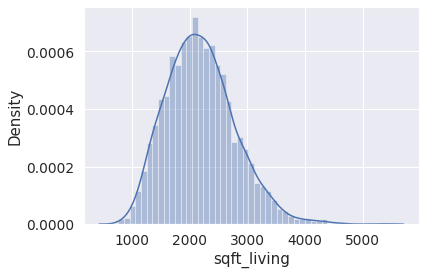

In [40]:
sns.distplot(df_train.loc[(df_train['grade'] == 8)]['sqft_living'])

- 같은 grade 8안에서 sqft_living이 엄청 큰 쪽에 속함을 확인할 수 있음
- 집안 면적이 넓어서 가격이 높은건가라는 생각도 든다.

##### 3) grade가 11인데 가격이 매우 높은경우

In [41]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [42]:
df_train.loc[(df_train['price']>15.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,15.770310,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
3134,3134,201408,15.532906,5,5.75,9200,35069,2.0,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
5108,5108,201410,15.856731,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
6469,6469,201409,15.744856,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


가격이 높은 다른 집들과 비교해보았을 때 재건축의 여부가 다른것을 확인할 수 있는데 재건축 후 상승할게 아닌가라는 생각이든다

Text(0.5, 1.0, '재건축 한 집들의 가격분포')

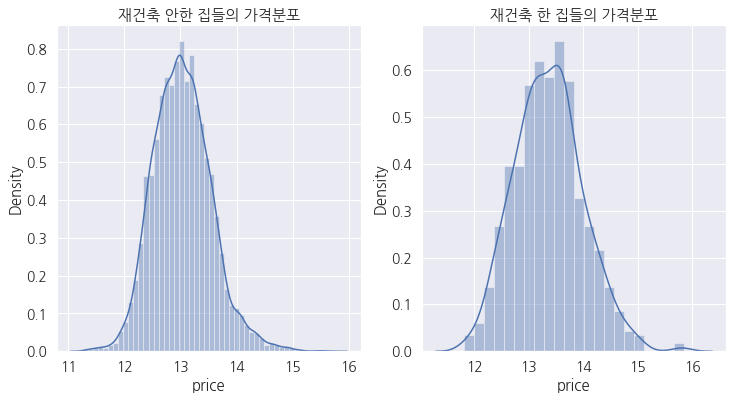

In [43]:
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'NanumGothic'

f, ax = plt.subplots(1, 2, figsize = (12, 6))

sns.distplot(df_train[df_train['yr_renovated'] ==0]['price'], ax = ax[0])
ax[0].set_title("재건축 안한 집들의 가격분포")
sns.distplot(df_train[df_train['yr_renovated'] !=0]['price'], ax = ax[1])
ax[1].set_title("재건축 한 집들의 가격분포")

재건축이 가격상승과 관련있다는 것은 분포가 보다 오른쪽으로 좀 더 이동했다는 것을 통해 확인할 수 있다.

### 2.2 변수 정규화

앞서 분포가 치우친 sqft_living, sqft_lot, sqft_above, sqft_basement에 대해서 정규화를 시켜준다.

skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train['date'] =df_train['date'].apply(lambda x: x[0:8])
    df_test['date'] =df_test['date'].apply(lambda x: x[0:8])
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

### 2.3 변수 수정

In [44]:
for df in [df_train, df_test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x : np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built']) 

## 3. 변수생성

In [45]:
df_original.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [46]:
for df in [df_train, df_test]:
    #방의 전체 갯수
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    #주거 공간의 비율
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    #면적 대비 주거공간 비율 
    df['sqft_ratio_1'] = df['sqft_above'] / df['sqft_living']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15']
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [47]:
df_train['per_price'] = df_train['price']/df_train['sqft_living']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

for df in [df_train,df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_living']
    df['zipcode_var'] = df['var'] * df['sqft_living']

In [48]:
for df in [df_train, df_test]:
    df = pd.concat([df, pd.get_dummies(df['zipcode'], prefix = 'zipcode')], axis = 1)
    #df['zipcode'] = le.fit_transform(df['zipcode'])

In [50]:
from sklearn.decomposition import PCA

In [51]:
for df in [df_train, df_test]:
    coord = df[['lat','long']]
    pca = PCA(n_components=2)
    pca.fit(coord)

    coord_pca = pca.transform(coord)

    df['coord_pca1'] = coord_pca[:, 0]
    df['coord_pca2'] = coord_pca[:, 1]

df_train = pd.concat([df_train, pd.get_dummies(df_train['zipcode'], prefix = 'zipcode')], axis = 1)

df_test = pd.concat([df_test, pd.get_dummies(df_test['zipcode'], prefix = 'zipcode')], axis = 1)

In [52]:
for df in [df_train,df_test]:
    del df['mean']
    del df['var']
    del df['zipcode']

In [53]:
del df_train['per_price']
del df_train['id']

In [54]:
del df_test['id']

['price' 'grade' 'sqft_living' 'sqft_living15' 'zipcode_mean' 'sqft_above'
 'bathrooms' 'total_rooms' 'coord_pca2' 'lat' 'zipcode_var' 'bedrooms'
 'floors' 'view' 'sqft_ratio' 'sqft_basement' 'sqft_ratio15' 'coord_pca1'
 'sqft_ratio_1' 'yr_renovated']


<AxesSubplot:>

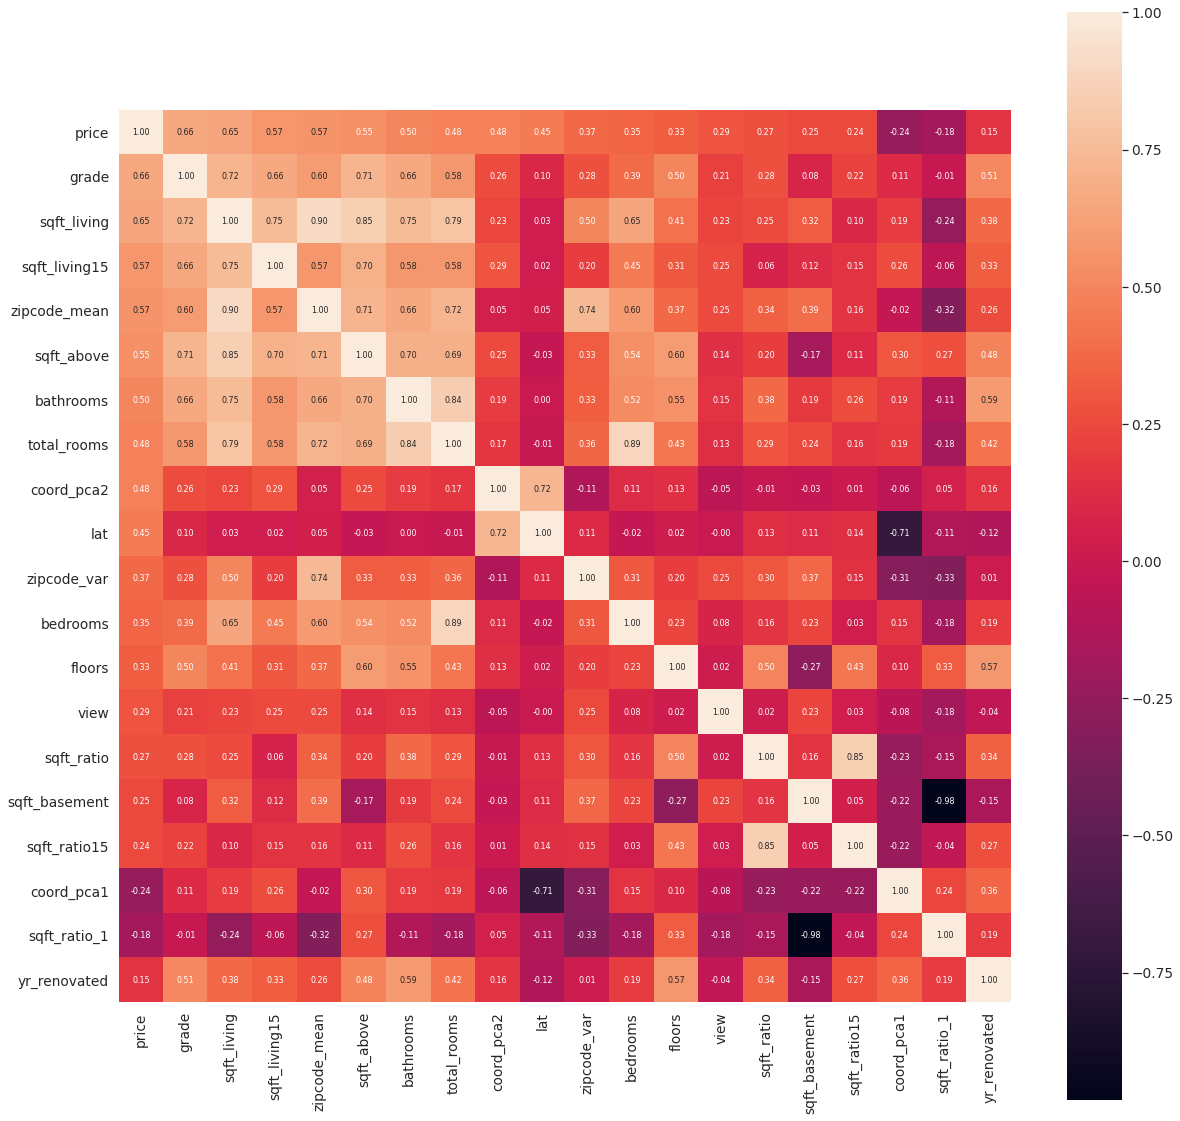

In [55]:
import scipy as sp

cor_abs = abs(df_train.corr(method = 'spearman'))
cor_cols = cor_abs.nlargest(20, columns = 'price').index #price와 correlation이 높은 column 10개 추출
#spearman coefficient matrix

cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0]
print(cor_cols.values)#
plt.figure(figsize = (20, 20))
sns.set(font_scale = 1.25)
sns.heatmap(cor, fmt = '.2f', annot = True, square = True, annot_kws = {'size' : 8}, xticklabels = cor_cols.values, yticklabels = cor_cols.values)

In [56]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [57]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, data, y, param_grid, verbose=2, n_jobs=5):
    """
    다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

    1. GridSearchCV 모델로 `model`을 초기화합니다.
    2. 모델을 fitting 합니다.
    3. params, score에 각 조합에 대한 결과를 저장합니다. 
    4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
    """
    model = LGBMRegressor(random_state=random_state)
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(data, y)
    column_list = ['params', 'mean_test_score']
    params, score = tuple(map(grid_model.cv_results_.get, column_list))
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    
    results = results.sort_values(['RMSLE'])
    return results

In [58]:
X_input = df_train.copy()
X_input.drop(['price'], axis = 1, inplace = True)
X = X_input
y = df_train['price']

In [59]:
test_X = df_test.copy()

### 그리드 서치 및 모델학습

In [74]:
param_grid = {
    'n_estimators': [250, 275, 300, 325, 350],
    'max_depth': [7, 10, 15],
    'num_leaves': [31, 63, 127]
}
random_state=42
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, X_input, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    8.9s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   53.3s
[Parallel(n_jobs=5)]: Done 225 out of 225 | elapsed:  1.5min finished


,max_depth,n_estimators,num_leaves,score,RMSLE
21,10,300,31,-0.026065,0.161446
18,10,275,31,-0.026091,0.161528
24,10,325,31,-0.026113,0.161594
15,10,250,31,-0.026114,0.161599
27,10,350,31,-0.026134,0.161661
33,15,275,31,-0.026141,0.161681
30,15,250,31,-0.026153,0.161718
36,15,300,31,-0.026179,0.161800
39,15,325,31,-0.026221,0.161928
42,15,350,31,-0.026271,0.162083


In [60]:
model = LGBMRegressor(num_leaves = 31, n_estimators = 300, max_depth = 10, random_state = 42)
model.fit(X_input, y)
prediction = model.predict(test_X)
prediction = np.expm1(prediction)
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: zipcode-3, zipcode-4, zipcode-5, zipcode-34, zipcode-45, zipcode-35

In [105]:
prediction = np.expm1(prediction)
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


## 회고

하나하나 설명을 뜯어보면서 eda를 진행하다보니 마지막에 시간이 부족해서 스코어를 낮추는데 실패했다 ㅠㅠㅠ

이것저것 커널을 보면서 보다 더 나은 분석을 할 수 있도록 노력해야겠다. 아직실력이많이부족하다는것을 느꼇다
